# "AI Text Agent: Entity Extraction & Summarizer Assistant"


### Importing Relevant libraries & Loading Unstructured Dataset (Reuters, Wikipedia, CSV )

In [4]:
import string
import nltk
import re
from transformers import pipeline
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import spacy
import pandas as pd
from nltk.corpus import reuters
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from langchain.agents import initialize_agent, Tool
from langchain_google_genai import GoogleGenerativeAI
from collections import Counter
import wikipediaapi
import matplotlib.pyplot as plt
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
nltk.download('reuters')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

 1. Loading Reuters

In [5]:
# Reuters loading
docs_reuters = [reuters.raw(doc_id) for doc_id in reuters.fileids() if doc_id.startswith('train')]
docs_reuters

2. Loading articles from Wikipedia

In [9]:
wiki = wikipediaapi.Wikipedia('my_takehome_assign_14','en')
topics = ['Artificial intelligence', 'Machine learning', 'Natural language processing']
docs_wiki = []
for topic in topics:
    page = wiki.page(topic)
    if page.exists():
        docs_wiki.append(page.text)

In [10]:
docs_wiki

['Artificial intelligence (AI) refers to the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals. Such machines may be called AIs.\nHigh-profile applications of AI include advanced web search engines (e.g., Google Search); recommendation systems (used by YouTube, Amazon, and Netflix); virtual assistants (e.g., Google Assistant, Siri, and Alexa); autonomous vehicles (e.g., Waymo); generative and creative tools (e.g., ChatGPT and AI art); and superhuman play and analysis in strategy games (e.g., chess and Go). However, many AI applications are not perceived as AI: "A lot of cutting edge AI has filtered into general appl

3.Loading Text from CSV

In [11]:


# Simulate a CSV
support_data = {
    'ticket_id': [1, 2, 3],
    'text': [
        "Customer reported late delivery on May 12, 2025.",
        "Package lost, request for refund initiated.",
        "Received damaged product, needs replacement. Incident on April 4, 2025."
    ]
}
df_support = pd.DataFrame(support_data)
docs_support = df_support['text'].tolist()
docs_support


['Customer reported late delivery on May 12, 2025.',
 'Package lost, request for refund initiated.',
 'Received damaged product, needs replacement. Incident on April 4, 2025.']

4. Combine all datasets


In [12]:
all_docs = docs_reuters + docs_wiki + docs_support


## 1. PREPROCESSING


In [13]:
# Load Reuters corpus
documents = reuters.fileids()
docs = [' '.join(reuters.words(fileid)) for fileid in documents if fileid.startswith('training/')]

# Preprocess
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    return ' '.join([word for word in tokens if word.isalpha() and word not in stop_words])

processed_docs = [preprocess(doc) for doc in docs]
processed_docs[0]

'bahia cocoa review showers continued throughout week bahia cocoa zone alleviating drought since early january improving prospects coming temporao although normal humidity levels restored comissaria smith said weekly review dry period means temporao late year arrivals week ended february bags kilos making cumulative total season mln stage last year seems cocoa delivered earlier consignment included arrivals figures comissaria smith said still doubt much old crop cocoa still available harvesting practically come end total bahia crop estimates around mln bags sales standing almost mln hundred thousand bags still hands farmers middlemen exporters processors doubts much cocoa would fit export shippers experiencing dificulties obtaining bahia superior certificates view lower quality recent weeks farmers sold good part cocoa held consignment comissaria smith said spot bean prices rose cruzados per arroba kilos bean shippers reluctant offer nearby shipment limited sales booked march shipment 

Pre-processing using Lemmatizer

Text Cleaning, Punctuation and stop words removal, lower casing

In [14]:
def preprocess_text(text):
        """Basic text preprocessing"""
        # Convert to lowercase
        text = text.lower()

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Tokenize
        tokens = nltk.word_tokenize(text)

        # Remove stopwords and lemmatize
        processed_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
        all_processed_docs=' '.join(processed_tokens)
        return processed_tokens

        #return processed_tokens


Comparing text Before and after pre- processing

In [15]:
preprocessed_docs = [preprocess_text(doc) for doc in all_docs]
df = pd.DataFrame({'original': all_docs, 'processed': preprocessed_docs})
df

,original,processed
0,BAHIA COCOA REVIEW\n Showers continued throug...,"[bahia, cocoa, review, shower, continued, thro..."
1,COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES ...,"[computer, terminal, system, ltcpml, completes..."
2,N.Z. TRADING BANK DEPOSIT GROWTH RISES SLIGHTL...,"[nz, trading, bank, deposit, growth, rise, sli..."
3,NATIONAL AMUSEMENTS AGAIN UPS VIACOM &lt;VIA> ...,"[national, amusement, ups, viacom, ltvia, bid,..."
4,ROGERS &lt;ROG> SEES 1ST QTR NET UP SIGNIFICAN...,"[rogers, ltrog, see, 1st, qtr, net, significan..."
...,...,...
7770,Machine learning (ML) is a field of study in a...,"[machine, learning, ml, field, study, artifici..."
7771,Natural language processing (NLP) is a subfiel...,"[natural, language, processing, nlp, subfield,..."
7772,"Customer reported late delivery on May 12, 2025.","[customer, reported, late, delivery, may, 12, ..."
7773,"Package lost, request for refund initiated.","[package, lost, request, refund, initiated]"


 Combined Pre-Processed docs

In [16]:
def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    return ' '.join([word for word in tokens if word.isalpha() and word not in stop_words])

all_processed_docs = [preprocess(doc) for doc in all_docs]
all_processed_docs[0]

'bahia cocoa review showers continued throughout week bahia cocoa zone alleviating drought since early january improving prospects coming temporao although normal humidity levels restored comissaria smith said weekly review dry period means temporao late year arrivals week ended february bags kilos making cumulative total season mln stage last year seems cocoa delivered earlier consignment included arrivals figures comissaria smith said still doubt much old crop cocoa still available harvesting practically come end total bahia crop estimates around mln bags sales standing almost mln hundred thousand bags still hands farmers middlemen exporters processors doubts much cocoa would fit export shippers experiencing dificulties obtaining certificates view lower quality recent weeks farmers sold good part cocoa held consignment comissaria smith said spot bean prices rose cruzados per arroba kilos bean shippers reluctant offer nearby shipment limited sales booked march shipment dlrs per tonne 

### Exploratory Analysis

In [ ]:
#df.info()

In [ ]:
#df.describe()

Identifying Most frequent words

Most common words: [('said', 18844), ('mln', 13089), ('v', 9312), ('dlrs', 8778), ('pct', 7394), ('year', 5973), ('ct', 5929), ('net', 4562), ('loss', 4317), ('share', 4155)]


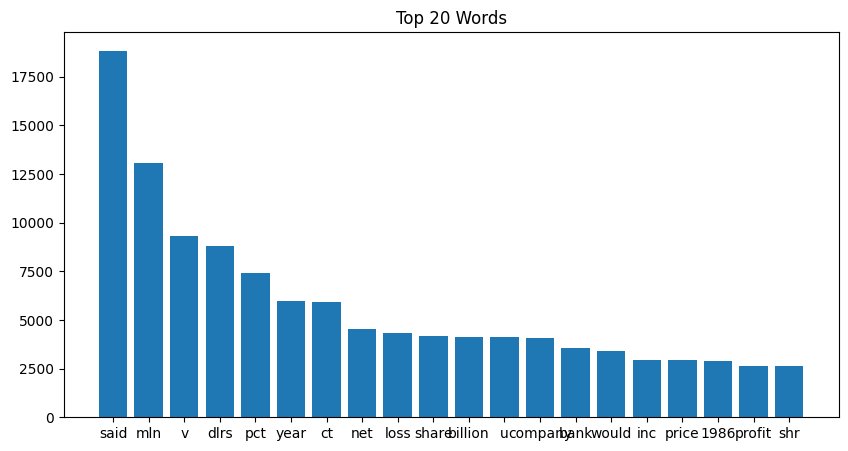

In [17]:


# Word frequency
all_tokens = [token for doc in preprocessed_docs for token in doc]
freq_dist = Counter(all_tokens)
print("Most common words:", freq_dist.most_common(10))

# Plot
plt.figure(figsize=(10,5))
plt.bar(*zip(*freq_dist.most_common(20)))
plt.title("Top 20 Words")
plt.show()


Analysing Document Length

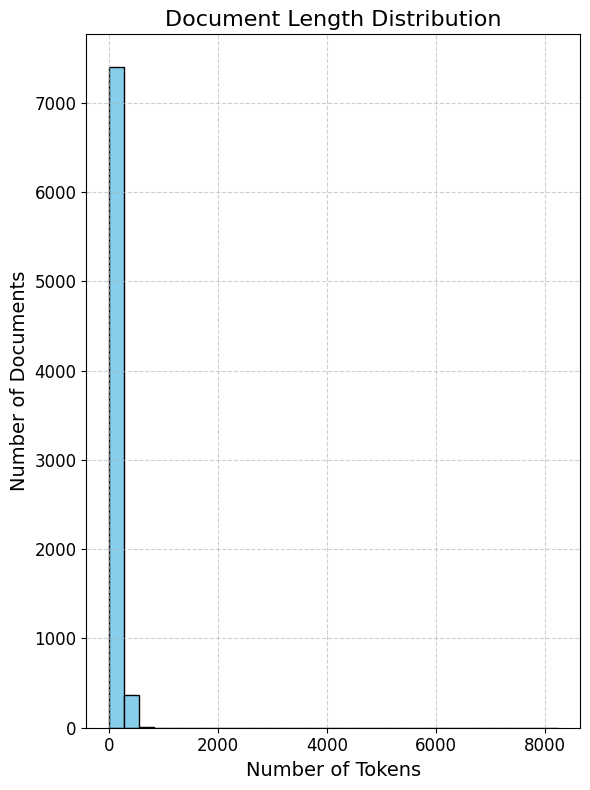

In [18]:


# Calculate document lengths
doc_lengths = [len(doc) for doc in preprocessed_docs]

# Plot histogram with improved visibility
plt.figure(figsize=(6, 8))
plt.hist(doc_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title("Document Length Distribution", fontsize=16)
plt.xlabel("Number of Tokens", fontsize=14)
plt.ylabel("Number of Documents", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


Word cloud

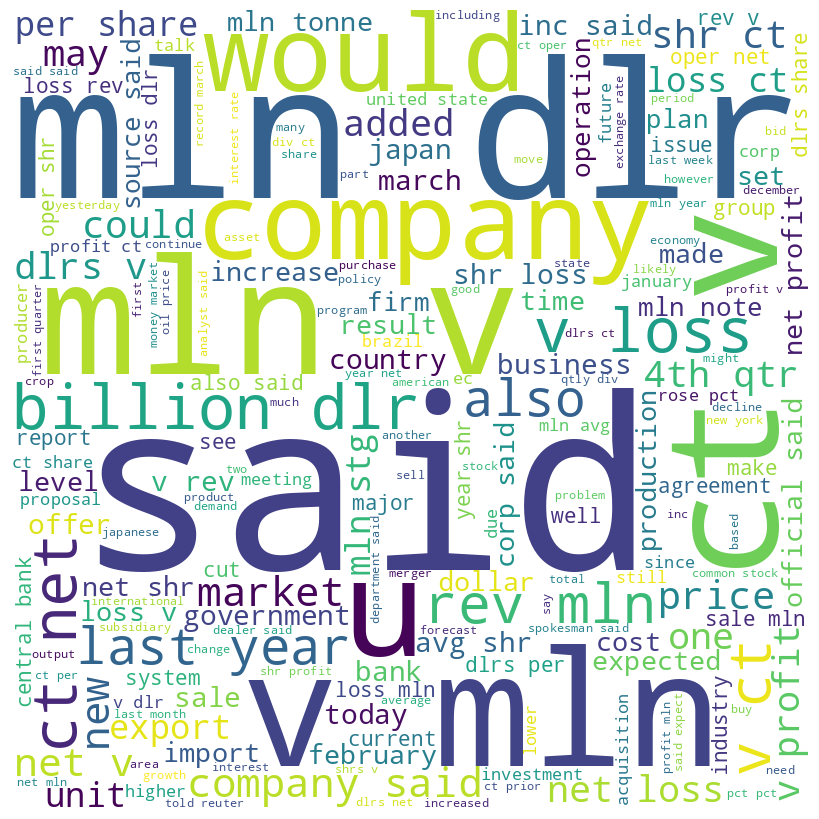

In [19]:


# Convert the list of lists of tokens into a single string
text_for_wordcloud = " ".join([" ".join(doc) for doc in preprocessed_docs])

# Generate a word cloud image
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(text_for_wordcloud)

# Display the generated image:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## 2. Information Extraction & Summarization

*   Entity Extraction (NER with SpaCy)
*   Rule-Based Extraction (Regex Example)
*   Sentiment Analysis (TextBlob for Simplicity)
*   Entity Extraction using Transformers (Recommended)
*   Summarization  Using Transformers






In [20]:

nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

print("Entities:", extract_entities(processed_docs[0]))


Entities: [('bahia cocoa review showers', 'ORG'), ('week', 'DATE'), ('early january', 'DATE'), ('smith', 'ORG'), ('weekly', 'DATE'), ('late year', 'DATE'), ('last year', 'DATE'), ('smith', 'ORG'), ('almost mln hundred thousand', 'MONEY'), ('recent weeks', 'DATE'), ('smith', 'ORG'), ('june july', 'DATE'), ('new york', 'GPE'), ('july', 'DATE'), ('march april', 'DATE'), ('april', 'DATE'), ('new york', 'GPE'), ('june july', 'DATE'), ('sept', 'CARDINAL'), ('new york', 'GPE'), ('oct', 'CARDINAL'), ('new york', 'GPE'), ('smith', 'ORG'), ('march april', 'DATE'), ('new york', 'GPE'), ('dec', 'CARDINAL'), ('march april', 'DATE'), ('june july', 'DATE'), ('new york', 'GPE'), ('july', 'DATE'), ('sept', 'CARDINAL'), ('new york', 'GPE'), ('oct', 'CARDINAL'), ('dec', 'CARDINAL'), ('new york', 'GPE'), ('smith', 'ORG'), ('midday', 'TIME'), ('february', 'DATE')]


b. Rule-Based Extraction (Regex Example)

In [21]:


def extract_dates(text):
    # Matches formats like: 12 May 2025, May 2025, May 5, 2025
    pattern = r'\b(?:\d{1,2}\s)?(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|' \
              r'May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:t(?:ember)?)?|Oct(?:ober)?|' \
              r'Nov(?:ember)?|Dec(?:ember)?)(?:\s\d{1,2})?,?\s\d{4}\b'
    matches = re.findall(pattern, text)
    return matches

# Example usage
sample_text = all_docs[7772] if all_docs and len(all_docs) > 0 else "No documents loaded"
print("Sample Text:", sample_text[:300])  # Print first 300 chars for context
print("Extracted Dates:", extract_dates(sample_text))


Sample Text: Customer reported late delivery on May 12, 2025.
Extracted Dates: ['May 12, 2025']


c. Sentiment Analysis (TextBlob for Simplicity)


In [23]:
from textblob import TextBlob

def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        sentiment = 'Positive'
    elif polarity < 0:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    return sentiment, polarity

# Example usage
sample_text = all_docs[0] if all_docs and len(all_docs) > 0 else "No document found."
sentiment, score = get_sentiment(sample_text)

print("Sentiment:", sentiment)
print("Polarity Score:", score)

Sentiment: Positive
Polarity Score: 0.11264186264186263


d. Entity Extracton using Transformers (Recommended)

In [42]:
# Initialize the entity extraction pipeline using DistilBERT
ner_pipeline = pipeline("ner", model="dslim/bert-base-NER", grouped_entities=True)

def extract_entities(text: str) -> str:
    """
    Extract named entities from input text using DistilBERT NER model.

    Parameters:
        text (str): The input text to extract entities from.

    Returns:
        str: A formatted string with each entity and its type.
    """
    entities = ner_pipeline(text)
    if not entities:
        return "No entities found."

    return "\n".join([f"{ent['entity_group']}: {ent['word']}" for ent in entities])
sample_text = all_docs[0] if all_docs and len(all_docs) > 0 else "No document found."
sentiment, score = get_sentiment(sample_text)
print(extract_entities(all_processed_docs))

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


TypeError: list indices must be integers or slices, not str

## Summarization

e. Using Transformers

In [39]:


summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def get_summary(text):
    if len(text.split()) < 50:
        return text  # skip very short text
    return summarizer(text, max_length=90, min_length=30, do_sample=False)[0]['summary_text']

# Join all processed docs into one text
joined_text = (all_processed_docs[0])

# Generate summary
print("Summary:", get_summary(joined_text))


Device set to use cpu


Summary: Bahia cocoa zone alleviating drought since early january improving prospects coming temporao although normal humidity levels restored. spot bean prices rose cruzados per arroba kilos bean shippers reluctant offer nearby shipment limited sales booked march shipment dlrs per tonne ports named new crop sales.


## 3. Agents for Entity Extraction and summarization

In [35]:


# Initialize the entity extraction pipeline using DistilBERT
ner_pipeline = pipeline("ner", model="dslim/bert-base-NER", grouped_entities=True)

def extract_entities(text: str) -> str:
    entities = ner_pipeline(text)
    return "\n".join([f"{ent['entity_group']}: {ent['word']}" for ent in entities])

# Initialize the summarization pipeline using BART
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def summarize_text(text: str) -> str:
    result = summarizer(text, max_length=150, min_length=30, do_sample=False)
    return result[0]['summary_text']

# Define tools for the agent
tools = [
    Tool(
        name="Entity Extractor",
        func=extract_entities,
        description="Use this tool when the user wants to extract entities like names, dates, locations, etc."
    ),
    Tool(
        name="Text Summarizer",
        func=summarize_text,
        description="Use this tool when the user wants a summary of a long text or paragraph."
    )
]

# Initialize the LLM with GooglePalm
llm = GoogleGenerativeAI(model="models/gemini-1.5-flash", google_api_key="Your-Google-API-KEY")


# Create the agent with the tools and LLM
agent = initialize_agent(tools, llm, agent="zero-shot-react-description", verbose=True)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(
Device set to use cpu


Testing Agent with Query Example

In [36]:
# Example usage
query = "Extract entities from this paragraph: John met Angela in New York on January 15th, 2023."
response = agent.run(query)
print("Response:", response)



> Entering new AgentExecutor chain...
Thought: I need to extract the entities (names, location, date) from the given paragraph.  The Entity Extractor tool is suitable for this task.
Action: Entity Extractor
Action Input: "John met Angela in New York on January 15th, 2023."
Observation: PER: John
PER: Angela
LOC: New York
Thought:Question: Extract entities from this paragraph: John met Angela in New York on January 15th, 2023.
Thought: I need to extract the entities (names, location, date) from the given paragraph.  The Entity Extractor tool is suitable for this task.
Action: Entity Extractor
Action Input: "John met Angela in New York on January 15th, 2023."
Observation: PER: John
PER: Angela
LOC: New York
Thought:Question: Extract entities from this paragraph: John met Angela in New York on January 15th, 2023.
Thought: I need to extract the entities (names, location, date) from the given paragraph.  The Entity Extractor tool is suitable for this task.
Action: Entity Extractor
Action 

In [ ]:
# Example usage
# query = "Summarize from this paragraph: John met Angela in New York on January 15th, 2023."
# response = agent.run(query)
# print("Response:", response)